# Null hypothesis: There is no difference in similarities of documents analyzed through by Doc2Vec and Word2Vec

# Alternate hypothesis: There are differences in similarities of documents  analyzed through Doc2Vec and Word2Vec

In [45]:
import pandas as pd

In [46]:
from gensim.models import doc2vec
from gensim.models import word2vec

In [47]:
def label_sentence(sentence, label):
    return doc2vec.LabeledSentence(words=sentence, tags=[label])

In [48]:
df = pd.read_csv("./billboard.csv",encoding="latin")

In [49]:
df = df.dropna()
df = df[df['Lyrics']!="instrumental"]

In [50]:
df.drop('Rank',axis=1)
df = df.reset_index(drop=True)

In [51]:
song_id=2178
song_name = df.iloc[song_id]['Song']+" - "+df.iloc[song_id]['Artist']
print(song_name)

never gonna give you up - rick astley


# Preparing Labelled Sentences for training Doc2Vec

In [52]:
docs = []
for i in range(len(df)):
    row = df.iloc[i]
    lyrics = row['Lyrics']
    if(lyrics != "instrumental"):
        docs.append(label_sentence(lyrics,str(i)))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  


# Training Doc2Vec and Word2Vec on same set of Lyrics (Billboard songs 1965 - 2015)

In [53]:
d2v = doc2vec.Doc2Vec(docs, size=300, window=8, min_count=5, workers=4)
w2v = word2vec.Word2Vec(df['Lyrics'].apply(lambda x:x.split(" ")), size=300, window= 8, min_count=5,workers=4)

/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [54]:
d2v_sim = [None]*len(df)
for i,d in d2v.docvecs.most_similar(str(song_id),topn=len(df)):
    d2v_sim[int(i)] = d

# Adding Doc2Vec similarity of {{song_name}} lyrics to lyrics of all other songs to data frame column 

In [55]:
df['d2v_similarity']=d2v_sim

In [56]:
import numpy as np

def normalize(word_vec):
    norm=np.linalg.norm(word_vec)
    if norm == 0: 
       return word_vec
    return word_vec/norm
def getWord2VecSentenceVector(sentence):
    sentence = sentence.split(" ")
    vector = None
    i = 0
    for word in sentence:
        try:
            v = w2v[word]
            if(vector is None):
                vector = v
                i+=1
            else:
                vector =vector+v
        except:
            continue
    vector /= i
    return normalize(vector)

# Adding Word2Vec similarity of {{song_name}} lyrics to lyrics of all other songs to data frame column 

In [57]:
df['w2v_vector'] = df['Lyrics'].apply(getWord2VecSentenceVector)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [58]:
from scipy.spatial.distance import cosine
rick_roll = getWord2VecSentenceVector(df.iloc[song_id]['Lyrics'])
df['w2v_similarity'] = df['w2v_vector'].apply(lambda x:cosine(x,rick_roll))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [59]:
import matplotlib.pyplot as plt

Text(0.5,1,'Year vs Difference in Similarity between W2V and D2V')

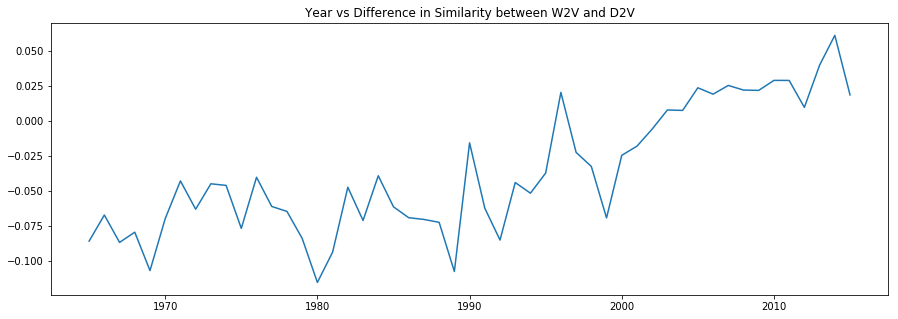

In [60]:
plt.figure(figsize=(15,5))
plt.plot(df.groupby("Year").mean().index,df.groupby("Year").mean()['w2v_similarity']-df.groupby("Year").mean()['d2v_similarity'])
plt.title("Year vs Difference in Similarity between W2V and D2V")

Text(0.5,0,'Year')

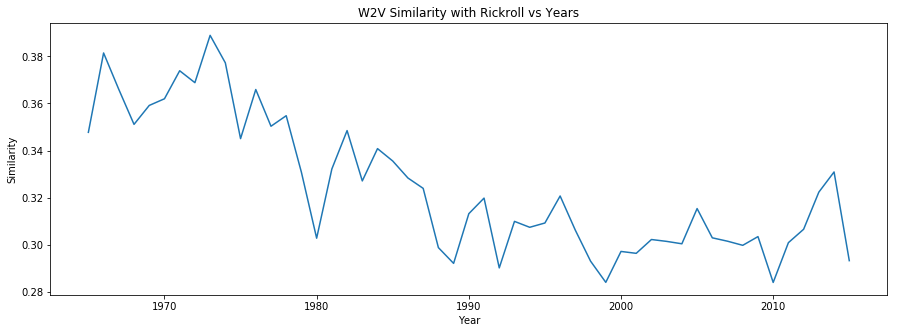

In [61]:
plt.figure(figsize=(15,5))
plt.plot(df.groupby("Year").mean()['w2v_similarity'])
plt.title("W2V Similarity with Rickroll vs Years")
plt.ylabel("Similarity")
plt.xlabel("Year")

Text(0.5,0,'Year')

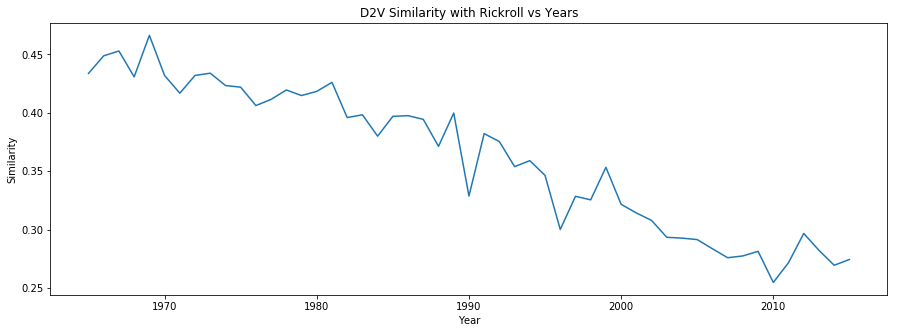

In [62]:
plt.figure(figsize=(15,5))
plt.plot(df.groupby("Year").mean()['d2v_similarity'])
plt.title("D2V Similarity with Rickroll vs Years")
plt.ylabel("Similarity")
plt.xlabel("Year")

# Finding number of songs where Doc2Vec and Word2Vec share cosine similarity within 10% range

In [63]:
num_similar_songs = len([x for x in (df['d2v_similarity']-df['w2v_similarity']).apply(lambda x:abs(x)) if x <= 0.1])

In [64]:
total_num_songs = len(df)

In [65]:
num_similar_songs/total_num_songs

0.26908942425479787

In [66]:
from annoy import AnnoyIndex

In [67]:
w2v_cluster = AnnoyIndex(300,metric='angular')

In [68]:
for i in range(len(df)):
    row = df.iloc[i]
    vector = row['w2v_vector']
    w2v_cluster.add_item(i,vector)

In [69]:
w2v_cluster.build(100)

True

# showing top 10 most similar songs to {{song_name}} using Word2Vec

In [70]:
for i in w2v_cluster.get_nns_by_vector(rick_roll,10):
    print(df.iloc[i]['Song'])
    print()
    print(df.iloc[i]['Lyrics'])
    print()

never gonna give you up

 ooh oohwere no strangers to love you know the rules and so do i a full commitments what im thinking of you wouldnt get this from any other guy i just wanna tell you how im feeling gotta make you understandnever gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt youweve known each other for so long your hearts been aching but youre too shy to say it inside we both know whats been going on we know the game and were gonna play it and if you ask me how im feeling dont tell me youre too blind to seenever gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt younever gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt youooh give you up ooh gi

# showing top 10 most similar songs to {{song_name}} using Doc2Vec

In [71]:
for i,d in d2v.docvecs.most_similar(str(song_id),topn=10):
    print(df.iloc[int(i)]['Song'])
    print()
    print(df.iloc[int(i)]['Lyrics'])
    print()

please dont go

we love you yeah lee we love you so we want you to know that were going to miss your love the minute you walk out that door so please dont go dont go dont go to cleeve please dont go dont go were begging you dont leave if you leave at least in our lifetime weve had one dream come true we were blessed to be loved by someone as wonderful as you so please dont go dont go dont go to cleeve please dont go dont go were begging you dont leave hey hey hey yeah lee we love you so we want you to know that were going to miss your love the minute you walk out that door so please dont go dont go dont go away hey hey hey i need your love were down on our knees beggin please please please dont go dont you hear me baby please dont go dont leave me now oh no no no no please dont go we want you to know that we we we love you so dont leave me baby please dont go

betcha by golly wow

 theres a spark of magic in your eyes candyland appears each time you smile never thought that fairy tales

# Use chi-square test to show that the difference between Doc2Vec and Word2Vec are not the same

In [72]:
from scipy.stats import chisquare

In [73]:
df2 = df.dropna()

In [74]:
chisquare(f_obs=df2['d2v_similarity'],f_exp=df2['w2v_similarity'],ddof=len(df2)-1)

Power_divergenceResult(statistic=1139.3994267306816, pvalue=nan)

In [75]:
len(df2)

4897

In [76]:
df2['d2v_similarity'] = df2['d2v_similarity'].apply(lambda x:round(x,1))
df2['w2v_similarity'] = df2['w2v_similarity'].apply(lambda x:round(x,1))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Doc2Vec Similarity Frequency Distribution

Text(0,0.5,'Frequency')

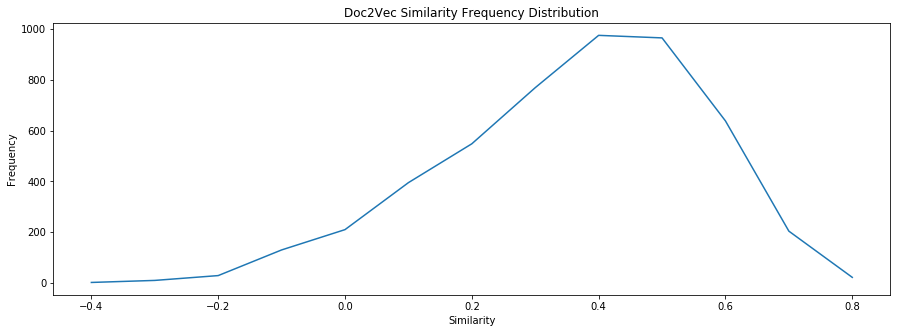

In [77]:
plt.figure(figsize=(15,5))
plt.plot(df2.groupby('d2v_similarity').count()['Rank'])
plt.title("Doc2Vec Similarity Frequency Distribution")
plt.xlabel("Similarity")
plt.ylabel("Frequency")

# Word2Vec Similarity Frequency Distribution

Text(0,0.5,'Frequency')

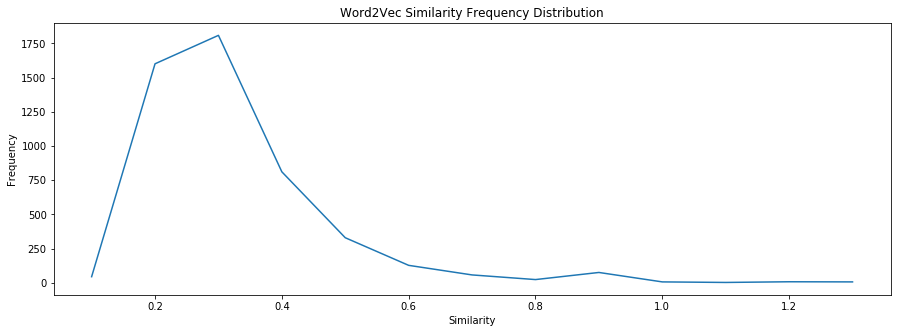

In [78]:
plt.figure(figsize=(15,5))
plt.plot(df2.groupby('w2v_similarity').count()['Rank'])
plt.title("Word2Vec Similarity Frequency Distribution")
plt.xlabel("Similarity")
plt.ylabel("Frequency")

# Word2Vec Mean Median Mode Std.deviation

In [79]:
print(df2['w2v_similarity'].mean())
print(df2['w2v_similarity'].median())
print(df2['w2v_similarity'].mode())
print(df2['w2v_similarity'].std())

0.32317745558505384
0.3
0    0.3
dtype: float64
0.14686216832496626


# Doc2Vec Mean Median Mode Std.deviation

In [80]:
print(df2['d2v_similarity'].mean())
print(df2['d2v_similarity'].median())
print(df2['d2v_similarity'].mode())
print(df2['d2v_similarity'].std())

0.3620379824382277
0.4
0    0.4
dtype: float64
0.20103534148094307


In [81]:
from scipy.stats.mstats import normaltest

## Normality Test rejects null hypothesis that W2V is normally distributed

In [82]:
normaltest(df2['w2v_similarity'])

NormaltestResult(statistic=2350.0008394744573, pvalue=0.0)

## Normality Test rejects null hypothesis that D2V is normally distributed

In [83]:
normaltest(df2['d2v_similarity'])

NormaltestResult(statistic=194.9220214254675, pvalue=4.712168879508571e-43)

# Finding lyrics with greatest difference in similarity results produced by Doc2Vec and Word2Vec

In [84]:
df3 = df
df3['x'] = abs(df['d2v_similarity']-df['w2v_similarity'])

In [85]:
df3.nlargest(10,'x')

,Rank,Song,Artist,Year,Lyrics,Source,d2v_similarity,w2v_vector,w2v_similarity,x
3044,98,macarena,los del r'io,1996,dale a tu cuerpo alegria macarena que tu cuer...,1.0,-0.226525,"[0.05006559, -0.029602192, 0.060282513, 0.1008...",1.313863,1.540388
3122,82,macarena bayside boys mix,los del r'io,1997,dale a tu cuerpo alegria macarena que tu cuer...,1.0,-0.213047,"[0.05006559, -0.029602192, 0.060282513, 0.1008...",1.313863,1.526910
4894,96,el perdon,nicky jam and enrique iglesias,2015,enrique iglesias dime si es verdad me dijeron ...,3.0,-0.339281,"[0.014169728, 0.02669766, 0.09406358, 0.044341...",1.153610,1.492892
2957,1,macarena bayside boys mix,los del r'io,1996,dale a tu cuerpo alegria macarena que tu cuer...,1.0,-0.152460,"[0.05006559, -0.029602192, 0.060282513, 0.1008...",1.313863,1.466323
3882,60,la tortura,shakira featuring alejandro sanz,2005,ay padrita mÌ_a guÌÁrdate la poesÌ_a guÌÁrdat...,1.0,-0.126720,"[0.034625478, 0.0006463096, 0.10063952, 0.0806...",1.209981,1.336701
4738,38,bailando,enrique iglesias featuring descemer bueno and ...,2014,yo te miro se me corta la respiraciÌ_n cuanto...,1.0,-0.093657,"[0.018985564, 0.014525034, 0.09592241, 0.08807...",1.101837,1.195494
654,100,somos novios its impossible,perry como,1971,feat christina aguileraandrea somos novios pu...,1.0,0.108871,"[0.039292477, -0.04510923, 0.07628422, 0.12364...",1.261086,1.152215
4548,45,rack city,tyga,2012,rack rack city bitch rack rack rack city bitc...,1.0,0.061057,"[0.068014614, -0.016297542, 0.023352684, 0.028...",1.152531,1.091473
2085,11,la bamba,los lobos,1987,para bailar la bamba para bailar la bamba se ...,1.0,0.211537,"[0.022328548, -0.0060041402, 0.079190716, 0.07...",1.280245,1.068709
549,82,the bells,the originals,1970,,1.0,-0.114770,"[0.051968478, -0.09953078, 0.011015526, 0.0935...",0.933008,1.047778


In [86]:
print(df.iloc[2178].Lyrics[:200],"...")
print('------------------------------------------------------------')
print(df.iloc[4894].Lyrics[:200],"...")
print()
print(df.iloc[2957].Lyrics[:200],"...")
print()
print(df.iloc[4548].Lyrics[:200],"...")
print()
print(df.iloc[3882].Lyrics[:200],"...")
print()
print(df.iloc[2085].Lyrics[:200],"...")

 ooh oohwere no strangers to love you know the rules and so do i a full commitments what im thinking of you wouldnt get this from any other guy i just wanna tell you how im feeling gotta make you unde ...
------------------------------------------------------------
enrique iglesias dime si es verdad me dijeron que te estas casando tÌ¼ no sabes lo estoy sufriendo esto te lo tengo que decir nicky jam cuÌ©ntame tu despedida para mi fue dura serÌÁ que te llevo a la  ...

 dale a tu cuerpo alegria macarena que tu cuerpo es pa darle alegria y cosa buena dale a tu cuerpo alegria macarena hey macarenadale a tu cuerpo alegria macarena que tu cuerpo es pa darle alegria y co ...

 rack rack city bitch rack rack rack city bitch rack rack rack rack city bitch mustard on the beat horack city bitch rack rack city bitch ten ten ten twenty on yo titties bitch 100 deep vip no guest l ...

 ay padrita mÌ_a guÌÁrdate la poesÌ_a guÌÁrdate la alegrÌ_a pa tidame dame dÌÁmelo ohno pido que todos los dÌ_as sea